In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, make_scorer, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tslearn.metrics import dtw

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import time
import random

# Data

Data was found from Kaggle at https://www.kaggle.com/code/mineshjethva/ecg-anomaly-detection.

Alternate link to the data: http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv.

The data contains 5000 time series of ECG data, labeled as normal or abnormal.

# Objective

Train a model to classify new ECG waveform as normal or abnormal. Column 140 identifies the class: 0 for Normal, 1 for Abnormal.

# Exploratory Data Analysis

In [3]:
#df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df = pd.read_csv('data/ecg.csv', header=None);

In [4]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


(4998, 141)

In [5]:
# Separate classes for EDA visualization
df_0 = df[df[140] == 0].iloc[:, :-1]     # 2070
df_1 = df[df[140] == 1].iloc[:, :-1]     # 2919

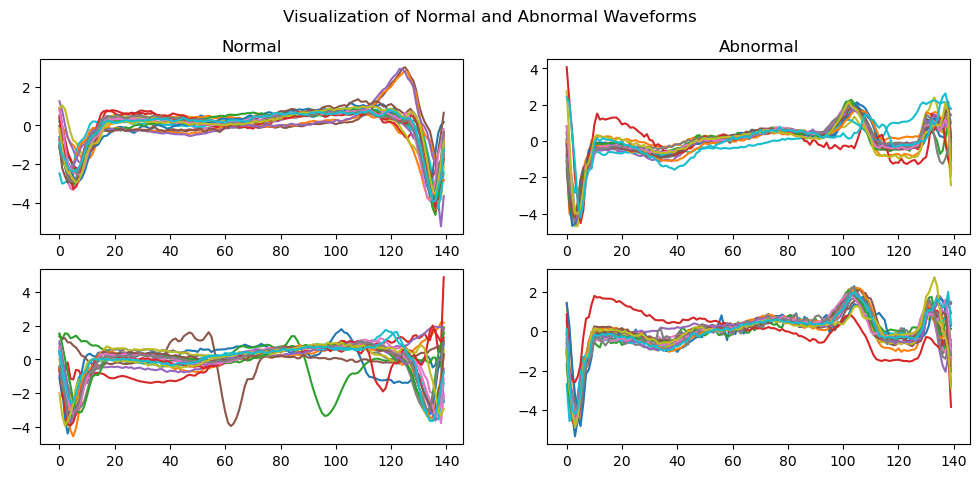

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle('Visualization of Normal and Abnormal Waveforms')
df_0.iloc[0:20,:].T.plot(kind='line', legend=False, ax=axes[0,0])
axes[0,0].set_title('Normal')
df_1.iloc[0:20,:].T.plot(kind='line', legend=False, ax=axes[0,1])
axes[0,1].set_title('Abnormal')
df_0.iloc[1000:1020,:].T.plot(kind='line', legend=False, ax=axes[1,0])
df_1.iloc[1000:1020,:].T.plot(kind='line', legend=False, ax=axes[1,1])
#df.iloc[130:135,:].T.mean(axis=1).plot(kind='line')
plt.savefig('images/visualization1.png')

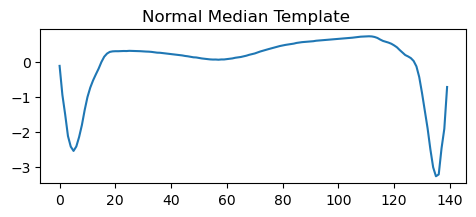

In [7]:
normal_median_template = df_0.iloc[:,:].median()
normal_median_template.plot(kind='line', figsize=(5.5,2))
plt.suptitle('Normal Median Template')
plt.savefig('images/normal-median-template.png')

## Observations
* Both the Normal and Abnormal waveforms present in a few distinct forms that seem legitimate, but some look like they were sliced improperly.
    * For example, in the lower left pane (1,0) above, a brown and green waveform show shapes in the middle that appear congruent with the shapes near the beginning in the majority of waveforms, leading to the supposition that those middle-located shapes should have been located near the beginning and were sliced incorrectly.
    * 🚩These badly sliced data would interfere, particularly with the Normal labeled data, and should be removed.
* Some waveforms appear to carry a trend, and may warrant detrending, if possible.
    * 💡This might be done by fitting a linear trend line for each waveform and subtracting it out. But it looks like this could easily add more error than it removes owing to the varying shapes and their amplitudes.

💡 Look into Matched Filter (like a point-by-point dot product). It maximizes SNR. It looks like cross-correlation.


## Data Cleaning

Locate bad data by sorting waveforms by similarity and inspecting the least similar.

In [8]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [9]:
# Calculate the unsimilarity between two vectors. Lower number is more similar.
def unsimilarity(a, b, method='xcor'):
    if method == 'xcor':
        return 1 / np.corrcoef(a, b)[0, 1]
        # One trial took 0.7 seconds
    elif method == 'mse':
        return mean_squared_error(a, b)    
    #On Speed: In one trial, xcor took 0.7 seconds while mse took 1.7 seconds.


# Single input, single output function that can be used as an argument to DataFrame.apply
def unsimilarity_vs_template(a):
    return unsimilarity(a, normal_median_template, 'mse')

# Calculate the unsimilarity between vector a and every vector in X, and return the vector of unsimilarities.
def unsimilarity_vect(a, X, similarity_strat='xcor'):
    return X.apply(lambda wfm: unsimilarity(wfm, a, similarity_strat), axis=1)

In [10]:
def plot_least_similar(X, label: object):
    unsimilarities = X.apply(unsimilarity_vs_template, axis=1)
    least_similar_idx = unsimilarities.sort_values(ascending=False).index.tolist()

    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle('Visualization of Lowest Similarity Waveforms: ' + label)
    axes = axes.flatten()

    num_wfm = 25
    for plt_i in range(len(axes)):
        s = slice(plt_i * num_wfm, (plt_i + 1) * num_wfm)
        X.loc[least_similar_idx[s]].T.plot(kind='line', legend=False, ax=axes[plt_i])
        axes[plt_i].set_title(f'{s.start} to {s.stop-1}')
    plt.tight_layout()

    return least_similar_idx


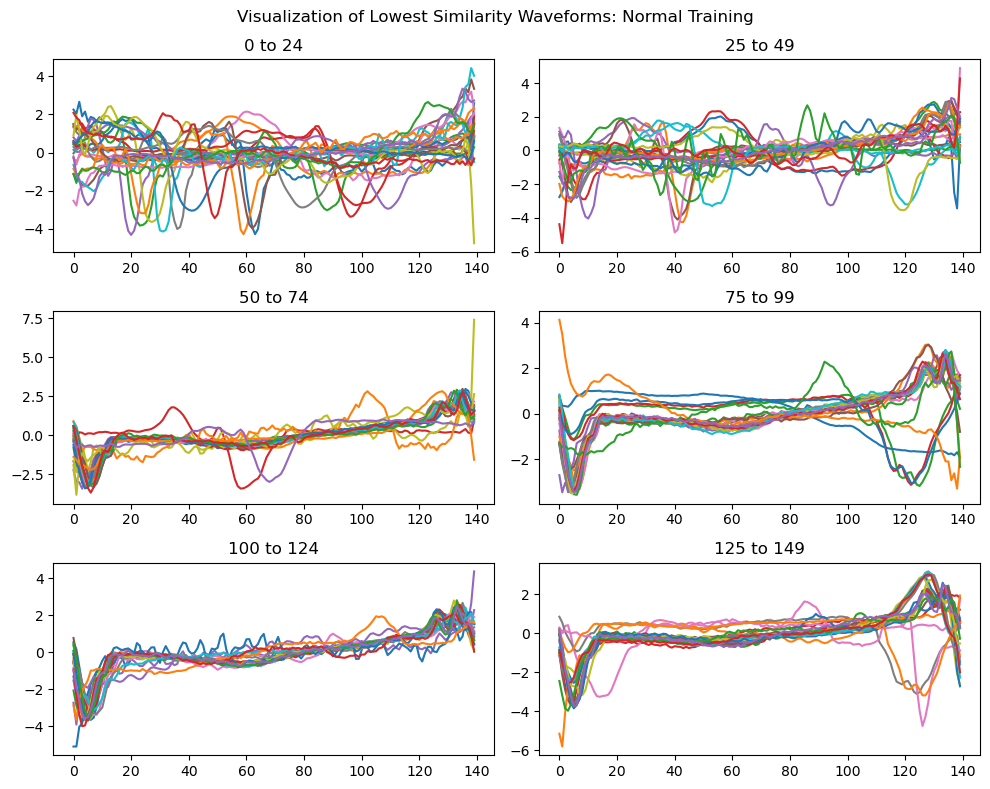

In [11]:
least_similar_idx = plot_least_similar(df_0, 'Normal Training')

Observation: The first hundred waveforms look like they contain false starts.

The process should be repeated on the whole data set.

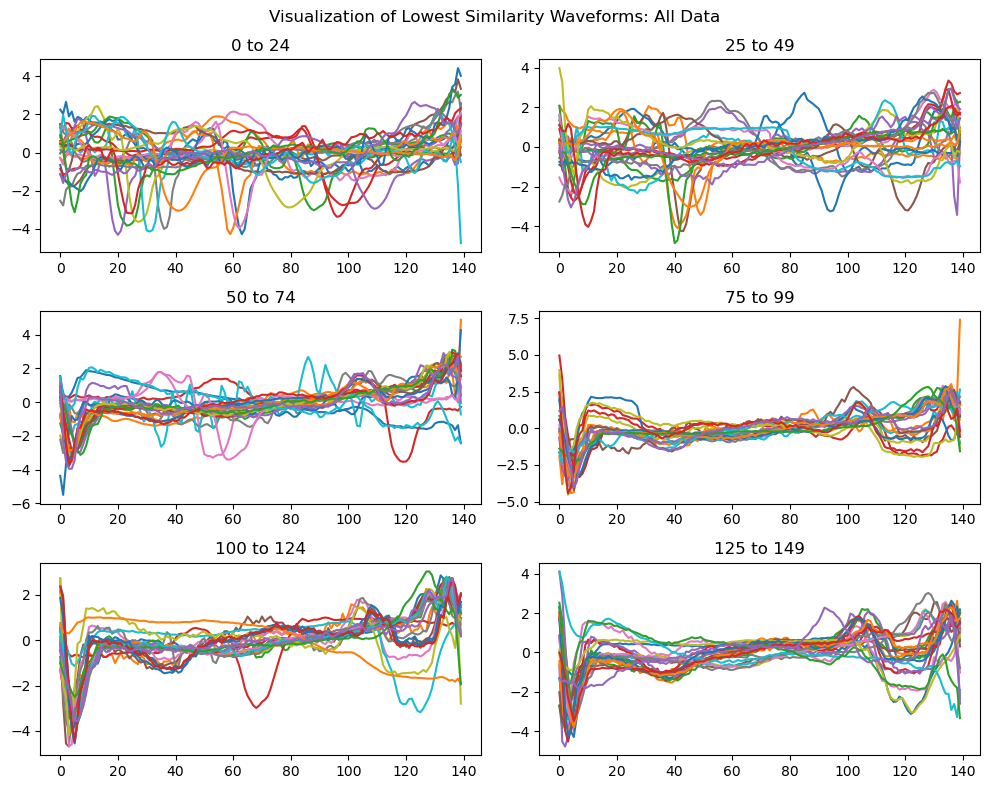

In [12]:
least_similar_idx = plot_least_similar(X, 'All Data')

In [13]:
# The shapes supposed to be false starts appear constrained to the first 125 samples.
X_clean = X.drop(least_similar_idx[0:124])
y_clean = y.drop(least_similar_idx[0:124])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, stratify=y_clean)

In [15]:
# Cleanup workspace
del df_0, df_1, least_similar_idx, X, y

# Model Evaluation

The following models will be evaluated primarily by $F_3$ score ($F_\beta$ where $\beta=3$), to account for the asymmetric cost of false negatives. It can be said that Recall is valued 3 times more important than Precision. Accuracy will also be measured.

$$F_\beta = \frac{(1 + \beta^2) \cdot Precision \cdot Recall}{\beta^2 \cdot Precision + Recall)}$$

$$F_3 = \frac{10 \cdot Precision \cdot Recall}{9 \cdot Precision + Recall)}$$

The metrics to be compared:
* $F_3$ score (on Train and Test sets)
* Accuracy (on Trian and Test sets)
* Training time


In [16]:
# Utility to record model results for final comparison
results_df = pd.DataFrame(columns = ['model_name', 'train_time', 'train_acc', 'train_f3', 'test_acc', 'test_f3'])

def reset_results():
    global results_df
    results_df = pd.DataFrame(columns = ['model_name', 'train_time', 'train_acc', 'train_f3', 'test_acc', 'test_f3'])

def record_results(model_name, train_time, train_acc, train_f3, test_acc, test_f3):
    results_df.loc[len(results_df)] = {
        'model_name': model_name,
        'train_time': train_time,
        'train_acc': train_acc,
        'train_f3': train_f3,
        'test_acc': test_acc,
        'test_f3': test_f3
}

## Baseline Statistical Model: Similarity Threshold vs Class Template

Before feature engineering and ML models are trained, a statistical baseline will be run.

The statistical baseline approach:
1. Compute a baseline template as a point-by-point median filter of the Normal class (y==0) waveforms in the Training set.
2. For each sample, compute the similarity to the template.
3. Find a similarity threshold value that optimizes a performance metric.

In [17]:
# Make baseline template from Training data
baseline_template = X_train[y_train == 0].iloc[:,:].median()

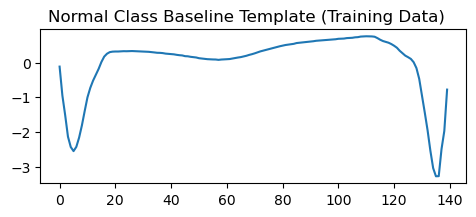

In [18]:
# Plot the baseline Training template
baseline_template.plot(kind='line', figsize=(5.5,2))
plt.suptitle("Normal Class Baseline Template (Training Data)")
plt.savefig('images/baseline-normal-template-train.png')

In [19]:
TH_TRAIN_FLAG = -1
def baseline_model_fit_score(template, X, y, label, th_in = TH_TRAIN_FLAG, similarity_strat='mse'):
    """
        th_in < 0: Train
            Fit model on (X,y) resulting in threshold. Use fit threshold to evaluate the model on (X,y).
        th_in >= 0: Test
            Use th_in to evaluate the model on (X,y) """
    
    t0 = time.time()

    unsimilarities = unsimilarity_vect(template, X, similarity_strat)

    # Grid search
    th_grid = np.linspace(unsimilarities.min(), unsimilarities.quantile(0.95), 50)
    acc = []
    f3 = []
    precision = []
    recall = []
    for th in th_grid:
        preds = np.where(unsimilarities < th, 0, 1)

        # For scoring
        acc.append(accuracy_score(y, preds))
        f3.append(fbeta_score(y, preds, beta=3))

        # For plotting
        precision.append(precision_score(y, preds))
        recall.append(recall_score(y, preds))

    train_time = time.time() - t0

    # Calculate model score
    score_df = pd.DataFrame({'threshold': th_grid, 'accuracy': acc, 'f3': f3, 'precision': precision, 'recall': recall})
    
    if th_in < 0:
        # Train: Select the best threshold from the threshold grid and score the model
        best_idx = np.argmax(score_df['f3'])
        model_th = score_df.loc[best_idx, 'threshold']
        f3_final = score_df.loc[best_idx, 'f3']
        acc_final = score_df.loc[best_idx, 'accuracy']
    else:
        # Test: Use the threshold passed in to score the model
        model_th = th_in
        preds = np.where(unsimilarities < model_th, 0, 1)
        f3_final = fbeta_score(y, preds, beta=3)
        acc_final = accuracy_score(y, preds)

    # Plots ...
    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    fig.suptitle('Baseline Model Score: ' + label + ' (using ' + similarity_strat + ')')

    # Plot 1: scores vs threshold
    score_df.plot(kind='line', x='threshold', y=['accuracy', 'precision', 'recall', 'f3'], ax=axes[0])
    axes[0].set_title('Scores vs Threshold')    
    axes[0].axvline(model_th, 0, 1, linestyle='--', color=(0,0,0), label=f'th={model_th}')
    
    # Plot 2: precision vs recall
    score_df.plot(kind='line', x='recall', y='precision', ax=axes[1])
    axes[1].set_title('Precision vs Recall')

    # Plot 3: confusion matrix
    preds = np.where(unsimilarities < model_th, 0, 1)
    ConfusionMatrixDisplay.from_predictions(y, preds, labels=[0, 1], ax=axes[2])

    plt.savefig('images/baseline-score-' + label + '-' + similarity_strat + '.png')

    print(f'{label:6} threshold :\t{model_th.round(3)}')
    print(f'{label:6} F3 score :\t{f3_final.round(3)}')
    print(f'{label:6} accuracy  :\t{round(acc_final, 3)}')

    return (train_time, model_th, f3_final, acc_final)

In [20]:
def run_baseline(baseline_template, X_train, y_train, X_test, y_test, similarity_strat = 'mse'):
    
    # Train
    train_time, baseline_th_train, baseline_f3_train, baseline_acc_train = baseline_model_fit_score(
        baseline_template, X_train, y_train, 'Training', th_in=TH_TRAIN_FLAG, similarity_strat=similarity_strat)
    
    # Test
    _, _, baseline_f3_test, baseline_acc_test = baseline_model_fit_score(
        baseline_template, X_test, y_test, 'Test', baseline_th_train, similarity_strat=similarity_strat)
    
    record_results('Baseline ' + similarity_strat, train_time, baseline_acc_train, baseline_f3_train, baseline_acc_test, baseline_f3_test)

Training threshold :	0.43
Training F3 score :	0.988
Training accuracy  :	0.928
Test   threshold :	0.43
Test   F3 score :	0.985
Test   accuracy  :	0.918


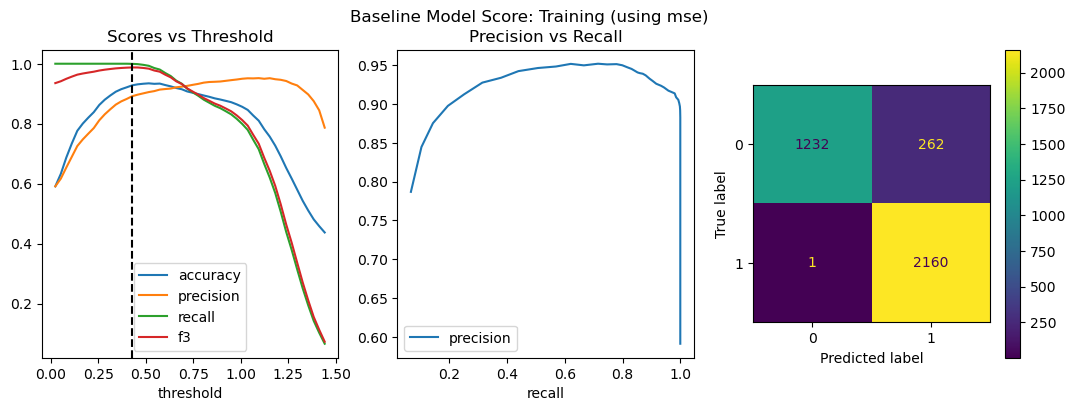

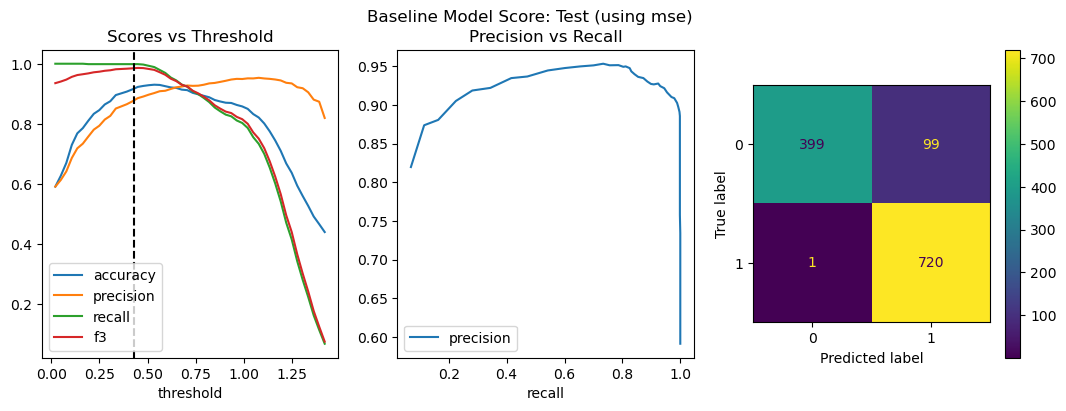

In [21]:
run_baseline(baseline_template, X_train, y_train, X_test, y_test, similarity_strat='mse')

Training threshold :	1.325
Training F3 score :	0.988
Training accuracy  :	0.93
Test   threshold :	1.325
Test   F3 score :	0.986
Test   accuracy  :	0.924


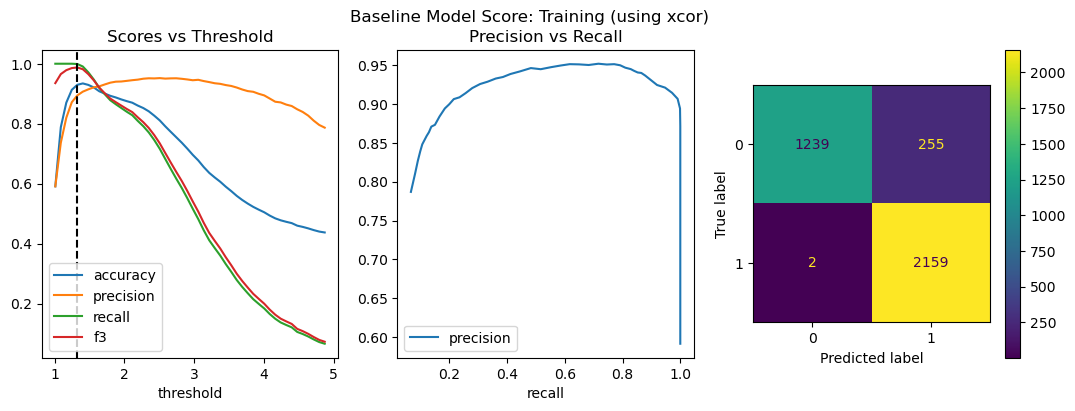

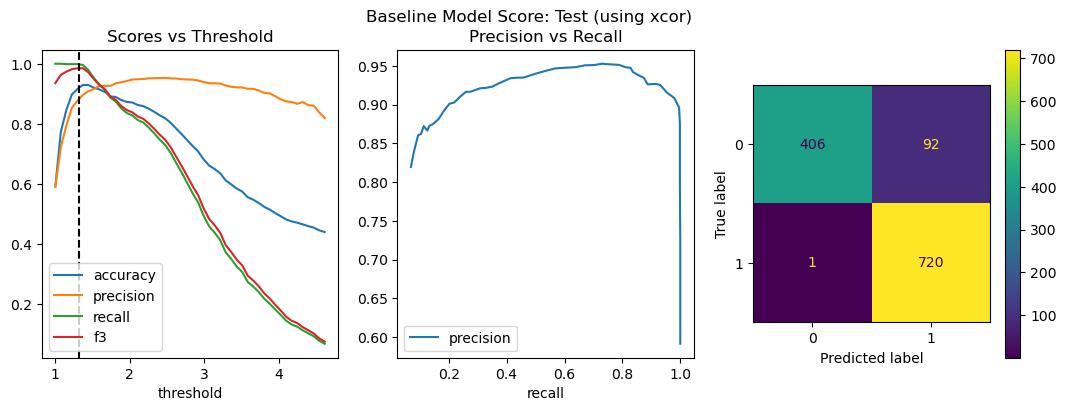

In [22]:
run_baseline(baseline_template, X_train, y_train, X_test, y_test, similarity_strat='xcor')

# Feature Engineering

The features for modeling are a set of similarity measurements to template waveforms. The template waveforms are selected with preference for dissimilarity as follows:
* Randomly downsample the training set to constrain the search space.
* Randomly select one waveform as a template.
* Include another sample as a template that is the most distinct from each already-accepted template.
* Repeat until a given number of templates have been chosen.

In [23]:
def min_unsimilarity_1(A, X, sim_strat):
    """Find the maximum unsimilarity between waveform A and all waveforms in X"""
    
    unsimilarities = X.apply(lambda wfm: unsimilarity(wfm, A, sim_strat), axis=1)
    return (unsimilarities.argmin(), unsimilarities.min())


In [24]:
def transfer_row(dst: pd.DataFrame, src: pd.DataFrame, idx: int) -> pd.DataFrame:
    dst = pd.concat([dst, src.iloc[idx,:].to_frame().T])
    src.drop(src.index[idx], inplace=True)
    return dst

def choose_distinct_waveforms(X, sim_strat='xcor', max_templates=10) -> list:
    X_maybe = X.sample(min(400, len(X)), random_state=99)   #limit search to a subset
    
    # Select first waveform at random (save as a DataFrame, not a Series)
    X_yes = X_maybe.iloc[random.randint(0, len(X_maybe)-1), :].to_frame().T

    # Loop, selecting additional waveforms that are the least similar
    for template_count in range(1, max_templates):

        # For each X_maybe sample remaining, find the highest unsimilarity with all accepted templates (X_yes)
        max_sim = 0
        i_yes = -1
        for i in range(0, len(X_maybe)):
            i_maybe, sim = min_unsimilarity_1(X_maybe.iloc[i,:], X_yes, sim_strat)
            if sim > max_sim:
                max_sim = sim
                i_yes = i_maybe
        
        # Save the highest unsimilarity template to X_yes and remove it from X_maybe
        X_yes = transfer_row(X_yes, X_maybe, i_yes)
        print(f'highest min unsimilarity: {max_sim}')

    return X_yes

highest min unsimilarity: 2.3429840178051426
highest min unsimilarity: 2.060884953232699
highest min unsimilarity: 2.060884953232699
highest min unsimilarity: 2.060884953232699
highest min unsimilarity: 2.060884953232699
highest min unsimilarity: 2.060884953232699
highest min unsimilarity: 1.604206026641987


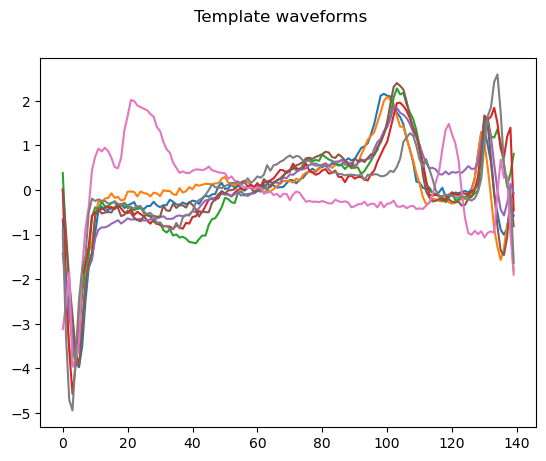

In [43]:
# Generate template waveforms
n = 8
seed = 11
sim_strat = 'mse'
random.seed(seed)

X_templates = choose_distinct_waveforms(X_train, sim_strat, max_templates=n)

X_templates.T.plot(kind='line', legend=False)
plt.suptitle('Template waveforms')
plt.savefig(f'images/templates-{sim_strat}-n{n}-seed{seed}.png')

In [ ]:
def make_features(X, X_templates, sim_strat):
    Xf = pd.DataFrame()
    for wfmi in range(0, len(X)):
        feat_s = unsimilarity_vect(X.iloc[wfmi,:] , X_templates, sim_strat)    # Series.T
        Xf = pd.concat([Xf, feat_s], axis=1)
    return Xf.T.reset_index(drop=True)

Xf_train = make_features(X_train, X_templates, sim_strat)
Xf_test  = make_features(X_test, X_templates, sim_strat)
# mse: 19 s
# xcor: 8.1 s

# Modeling

In [28]:
models = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 10]}),
    'Logistic': (LogisticRegression(max_iter=1000, ), {'C': [0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(), {
        'min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
        'max_depth': [5, 10, 15],
        'min_samples_split': [0.05, 0.1, 0.2]}),
    'SVC': (SVC(coef0=1, kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': [0.05, 0.1]})
}

In [29]:

def model_run_score(model, model_name, params, X_train, y_train, X_test, y_test):

    gscv = GridSearchCV(model, params, scoring=make_scorer(fbeta_score, beta=3), verbose=1)
    gscv.fit(X_train, y_train)
    train_time = gscv.cv_results_['mean_fit_time'].mean()

    clf = gscv.best_estimator_
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)
    f3_train = fbeta_score(y_train, clf.predict(X_train), beta=3)
    f3_test = fbeta_score(y_test, clf.predict(X_test), beta=3)

    print(f'train_time: {train_time}, train_acc: {acc_train}, test_acc: {acc_test}, f3_train: {f3_train}, f3_test: {f3_test}')
    record_results(model_name, train_time, acc_train, f3_train, acc_test, f3_test)

    return clf, gscv.best_params_

In [43]:
#results_df.drop(2)

## Explore the results of the Logistic Regression model

In [39]:
# Investigate the Logistic model carefully
clf, bp = model_run_score(models['Logistic'][0], f'Logistic ({sim_strat}, seed {seed})', models['Logistic'][1], Xf_train, y_train, Xf_test, y_test)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
train_time: 0.06380343437194824, train_acc: 0.6147742818057456, test_acc: 0.6259228876127974, f3_train: 0.9324688886955008, f3_test: 0.9309623430962343


In [40]:
# Inspect the template weights and their shape
clf.coef_

array([[-1.08733034e-05, -2.60404190e-03, -1.94116117e-03,
        -1.31391220e-03, -1.15012150e-01, -1.17634787e-04,
        -5.53362970e-05, -2.05558767e-05]])

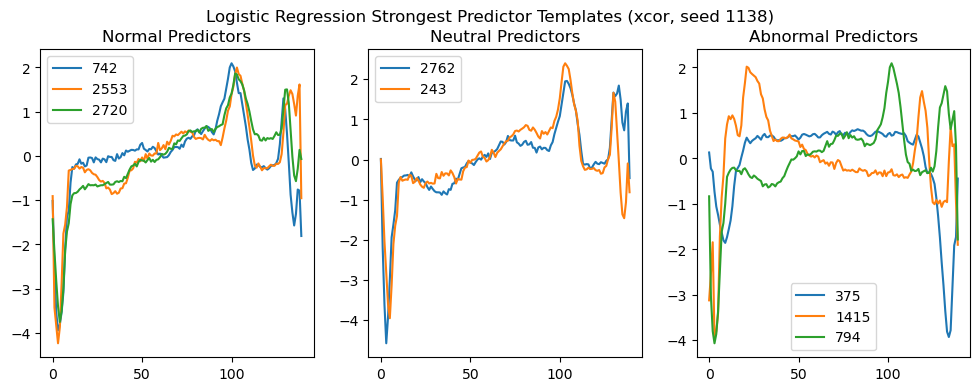

In [41]:
def plot_model_templates(X_templates, coef_, sim_strat, seed):
    coef = pd.DataFrame(clf.coef_.T)[0]
    normal_template_indices = (coef < coef.quantile(0.4)).T
    neutral_template_indices = ( (coef >= coef.quantile(0.4)) & (coef < coef.quantile(0.6)) ).T
    abnormal_template_indices = (coef >= coef.quantile(0.6)).T

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    X_templates[normal_template_indices.values].T.plot(kind='line', ax=axes[0])
    axes[0].set_title('Normal Predictors')
    X_templates[neutral_template_indices.values].T.plot(kind='line', ax=axes[1])
    axes[1].set_title('Neutral Predictors')
    X_templates[abnormal_template_indices.values].T.plot(kind='line', ax=axes[2])
    axes[2].set_title('Abnormal Predictors')
    plt.suptitle(f"Logistic Regression Strongest Predictor Templates ({sim_strat}, seed {seed})")
    plt.savefig(f'images/logistic-strongest-predictors-{sim_strat}-seed{seed}.png')

plot_model_templates(X_templates, clf.coef_, sim_strat, seed)

### Observations from Logistic Regression results

* The model predicted with about 98% accuracy and 0.99 F3 score on the Test set.
* The templates that the model chose to predict class are not easily distinguishable by eye. That is, a strong Normal template closely resembles a strong Abnormal template, making it difficult to show examples to a user.

In [ ]:
#results_df.reset_index(drop=True, inplace=True)
#results_df.drop(results_df.columns[6], axis=1, inplace=True)
#results_df.drop(4, inplace=True)
#results_df.at[3, 'model_name'] = 'Logistic (seed 1138)'

In [93]:
df.columns[6]

6

In [77]:
bp

{'C': 1}

In [ ]:
# TBD
# for model_name, model_grid in models.items():
#     model2_train_cv_score(model_grid[0], #model
#                          model_name,
#                          model_grid[1], #param_grid
#                          X_train_proc, y_train, X_test_proc, y_test)

# Results

In [42]:
print(results_df.round(4).to_markdown())

|    | model_name                 |   train_time |   train_acc |   train_f3 |   test_acc |   test_f3 |
|---:|:---------------------------|-------------:|------------:|-----------:|-----------:|----------:|
|  0 | Baseline mse               |       1.9024 |      0.928  |     0.9876 |     0.918  |    0.9852 |
|  1 | Baseline xcor              |       0.8792 |      0.9297 |     0.9875 |     0.9237 |    0.9862 |
|  2 | Logistic (xcor, seed 11)   |       0.033  |      0.6889 |     0.9329 |     0.6932 |    0.9303 |
|  3 | Logistic (xcor, seed 1138) |       0.0638 |      0.6148 |     0.9325 |     0.6259 |    0.931  |
